# Impedance vs. Parameter Measurements

This notebook is an example of how Python can be used to easily measure electrochemical methods multiple times with a varying parameter.

The example shows impedance spectra measured on a Schottky diode at different DC potentials.  
Schottky diodes have a smaller forward voltage of about 0.3 V than silicon diodes with about 0.7 V.

After the measurements, all impedance spectras are plotted together in a [contour plot](https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html#sphx-glr-gallery-images-contours-and-fields-contourf-log-py) with matplotlib.

## 1. Connect Python to the already launched Thales-Software

In [1]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import PotentiostatMode,ThalesRemoteScriptWrapper

"""
Import the ISM import package and the matplotlib plotting library.
"""
from thales_file_import.ism_import import IsmImport
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter, StrMethodFormatter
from matplotlib import ticker,colors,cm

if __name__ == "__main__":
    """
    The Thales software must first be started so that it can be connected.
    """
    ZenniumConnection = ThalesRemoteConnection()
    connectionSuccessful = ZenniumConnection.connectToTerm("localhost", "ScriptRemote")
    if connectionSuccessful:
        print("connection successfull")
    else:
        print("connection not possible")
        sys.exit()
    
    ZahnerZennium = ThalesRemoteScriptWrapper(ZenniumConnection)
    
    ZahnerZennium.forceThalesIntoRemoteScript()

connection successfull


## 2. Setting the parameters for the measurement

The output path is defined to which the measurement results are saved.  
And it is set that the measuring results are named individually.

Then the parameters for an impedance spectrum are set.

In [ ]:
    ZahnerZennium.setEISNaming("individual")
    ZahnerZennium.setEISOutputPath(r"C:\THALES\temp")
    
    ZahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
    ZahnerZennium.setAmplitude(10e-3)
    ZahnerZennium.setLowerFrequencyLimit(100)
    ZahnerZennium.setStartFrequency(100)
    ZahnerZennium.setUpperFrequencyLimit(500000)
    ZahnerZennium.setLowerNumberOfPeriods(10)
    ZahnerZennium.setLowerStepsPerDecade(10)
    ZahnerZennium.setUpperNumberOfPeriods(20)
    ZahnerZennium.setUpperStepsPerDecade(10)
    ZahnerZennium.setScanDirection("startToMin")
    ZahnerZennium.setScanStrategy("single")

## 3. Setting the DC parameters for the measurement

Since impedances are to be measured at different DC potentials, the potentials are stored in the array **potentialsToMeasure**.  
With np.linspace an array is created which contains 13 equally distributed values between 0 and 0.3.

In [2]:
    potentialsToMeasure = np.linspace(0,0.3,13)
    print(potentialsToMeasure)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3  ]


## 3. Execute the measurements

For each potential, the file name containing the DC potential is specified and the DC potential is set.  
The potential is stored in the filename in mV and converted to int, because you can not write floating point numbers into the filename, because of the decimal separator.   
The potentiostat is switched on before the EIS measurement that the measurement is executed on the DC potential instead of OCV/OCP.

In [ ]:
    for potential in potentialsToMeasure:
        ZahnerZennium.setEISOutputFileName("{:d}_mvdc".format(int(potential*1000)))
        ZahnerZennium.setPotential(potential)
    
        ZahnerZennium.enablePotentiostat()
        ZahnerZennium.measureEIS()
        ZahnerZennium.disablePotentiostat()
    
    ZenniumConnection.disconnectFromTerm()

## 4. Importing data from ISM files

The data is read from the ISM files and stored in arrays.

In [3]:
    absoluteImpedances = []
    phases = []
    
    ismFile = None
    for potential in potentialsToMeasure:
        ismFile = IsmImport(r"C:\THALES\temp\{:d}_mvdc.ism".format(int(potential*1000)))
        absoluteImpedances.append(ismFile.getImpedanceArray())
        phases.append(ismFile.getPhaseArray())

## 5. Preparing the data structures

For the representation with matplotlib it is best to use numpy arrays instead of Python arrays. Therefore numpy arrays are created from the Python arrays with np.array().  
The phase is also converted to degrees and absolute value.

With np.meshgrid() a two-dimensional array is created for X and Y, which is needed by the plotting function, because **absoluteImpedances** and **phases** are also two-dimensional arrays.

In [4]:
    absoluteImpedances = np.array(absoluteImpedances)
    phases = np.array(phases)
    phases = np.abs(phases * (360 / (2 * np.pi)))
    
    impedanceFrequencies = ismFile.getFrequencyArray()
    
    X,Y = np.meshgrid(impedanceFrequencies,potentialsToMeasure)

## 6. Plotting the data

The data is plotted with matplotlib as contourplot.  
First, the impedance spectras are plotted.

The X-axis corresponds to the frequency, the Y-axis is the DC potential and the impedance is represented by the color.

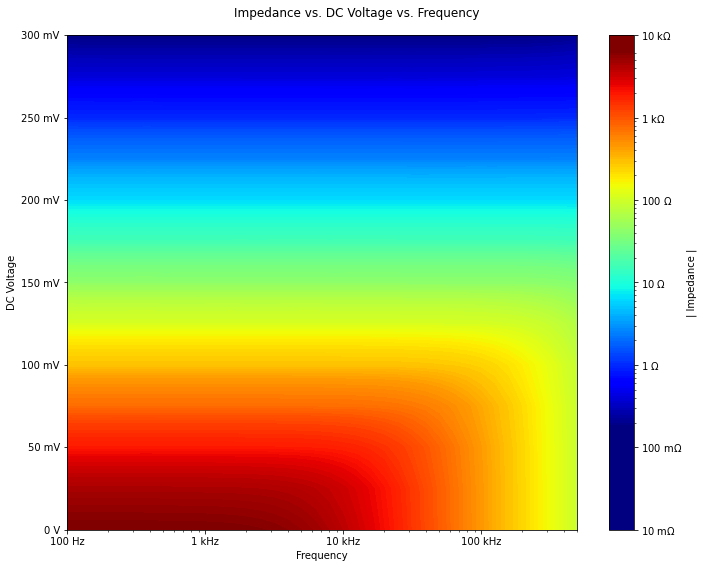

In [43]:
    impedanceFigure, impedancePlot = plt.subplots(1,1)
    impedanceFigure.suptitle("Impedance vs. DC Voltage vs. Frequency")
    
    ticks = np.power(10, np.arange(np.floor(np.log10(absoluteImpedances.min())-1), np.ceil(np.log10(absoluteImpedances.max())+1)))
    levels = np.logspace(np.floor(np.log10(absoluteImpedances.min())-1), np.ceil(np.log10(absoluteImpedances.max())), num=200)
    impedanceContour = impedancePlot.contourf(X, Y, absoluteImpedances, levels = levels, norm = colors.LogNorm(absoluteImpedances.min(), absoluteImpedances.max(), True), cmap="jet")
    
    impedancePlot.set_xlabel(r"Frequency")
    impedancePlot.set_xscale("log")
    impedancePlot.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    
    impedancePlot.set_ylabel(r"DC Voltage")
    impedancePlot.yaxis.set_major_formatter(EngFormatter(unit="V"))
    
    impedanceBar = impedanceFigure.colorbar(impedanceContour, ticks=ticks, format=EngFormatter(unit="$\Omega$"))
    impedanceBar.set_label('| Impedance |')
    impedanceFigure.set_size_inches(10, 8)
    plt.tight_layout()
    plt.show()

The second plot shows the phase.

This plot is basically the same as the impedance plot, but the settings of matplotlib are simpler, because the colors do not have to be scaled logarithmically.

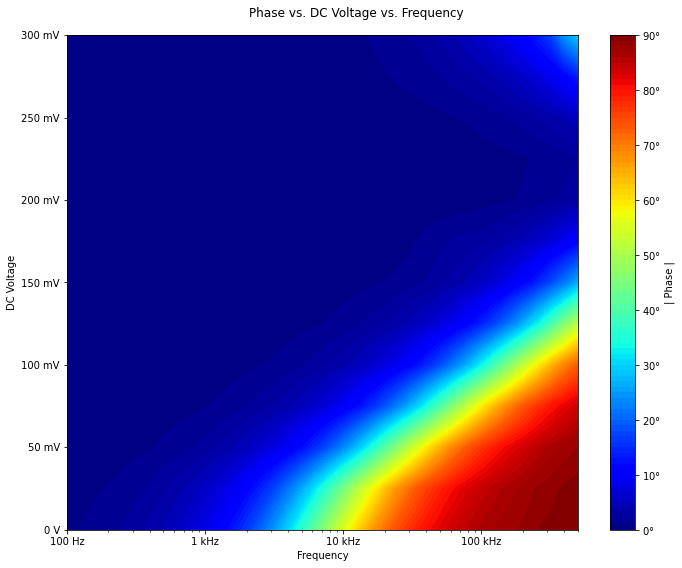

In [38]:
    phaseFigure, phasePlot = plt.subplots(1, 1)
    phaseFigure.suptitle("Phase vs. DC Voltage vs. Frequency")

    levels = np.linspace(phases.min(), phases.max(), 91)
    phaseContour = phasePlot.contourf(X, Y, phases, levels = levels, cmap="jet")

    phasePlot.set_xlabel(r"Frequency")
    phasePlot.set_xscale("log")
    phasePlot.xaxis.set_major_formatter(EngFormatter(unit="Hz"))

    phasePlot.set_ylabel(r"DC Voltage")
    phasePlot.yaxis.set_major_formatter(EngFormatter(unit="V"))

    phaseBar = phaseFigure.colorbar(phaseContour, format=StrMethodFormatter("{x:.0f}$°$"))
    phaseBar.set_label('| Phase |')

    phaseFigure.set_size_inches(10, 8)
    plt.tight_layout()
    plt.show()    

The previous plot shows that the impedance of the Schottky diode is high at low DC potential and in the high frequency region with 90 degrees phase capacitive behavior is present, which is due to the junction capacitance.  
With higher DC potential, the impedance becomes lower and lower as the diode begins to conduct.